## Assignment 3: Cost-Sensitive Logistic Regression

TEAM

1. AAYUSH SHRIVASTAVA                - CS24MTECH02001
2. ANISH PAWAR                       - AI23MTECH14002
3. ANKIT PANDEY                      - AI23MTECH13002
4. PUNEET KUMAR RAJAN                - AI23MTECH11010
5. VIVEK TARACHANDANI                - AI23MTECH14008

In [1]:
#Importing libraries
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Loading the data
dataset = pd.read_csv('C:\\Users\\india\\Downloads\\CS6890\\CS6890\\dataset.csv')

In [3]:
# Dataset Description
print("Dataset Description")
print(f"Number of variables:\t\t{len(dataset.columns)}")
print(f"Number of observations:\t\t{len(dataset)}")
print(f"Missing cells:\t\t\t{dataset.isnull().sum().sum()}")
print(f"Missing cells (%):\t\t{dataset.isnull().sum().sum() / (len(dataset) * len(dataset.columns)):.1%}")
duplicated_rows = dataset[dataset.duplicated()]
print(f"Duplicate rows:\t\t\t{len(duplicated_rows)}")
print(f"Duplicate rows (%):\t\t{len(duplicated_rows) / len(dataset):.1%}")
print(f"Total size in memory:\t\t{dataset.memory_usage(deep=True).sum() / (1024*1024):.1f} MiB")
print(f"Average record size in memory:\t{dataset.memory_usage(deep=True).sum() / len(dataset):.1f} B")

Dataset Description
Number of variables:		13
Number of observations:		147636
Missing cells:			0
Missing cells (%):		0.0%
Duplicate rows:			21621
Duplicate rows (%):		14.6%
Total size in memory:		14.6 MiB
Average record size in memory:	104.0 B


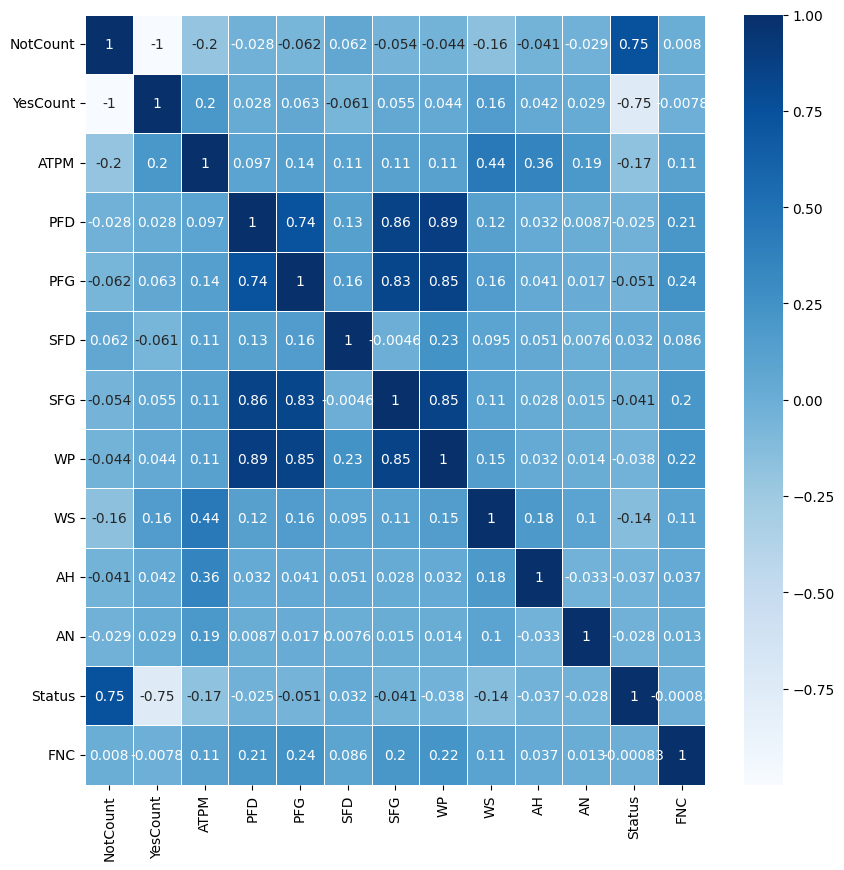

In [4]:
# Confusion Matrix (HeatMap)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(dataset.corr(), cmap = "Blues", annot = True, linewidth = 0.5, ax = ax)
plt.show()

In [5]:
# Count the number of data rows having status bit 1 and 0
ones = 0
zeros = 0
for i in dataset.loc[:,'Status']:
    if i == 1:
      ones += 1
    else:
      zeros += 1  
print("No of rows with status 1 are ", ones)
print("No of rows with status 0 are ", zeros)

No of rows with status 1 are  44082
No of rows with status 0 are  103554


C:\Users\india\AppData\Local\Temp\ipykernel_4864\3145159598.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(Z, color="green", shade=True)
C:\Users\india\AppData\Local\Temp\ipykernel_4864\3145159598.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(O, ax=g, color="red", shade=True)


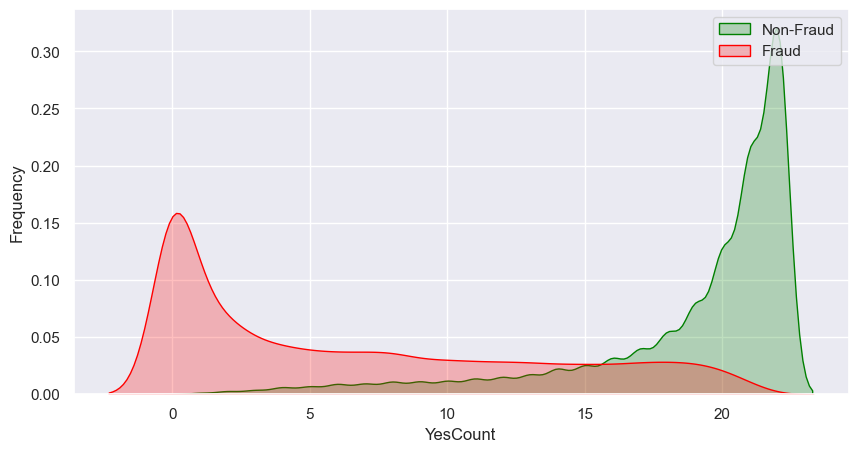

In [6]:
# Set the figure size
sns.set(rc={"figure.figsize": (10, 5)})

# Filter the dataset by non-null "YesCount" values and "Status" variable
Z = dataset.loc[(dataset["Status"] == 0) & (dataset["YesCount"].notnull()), "YesCount"] # Non-Fraud
O = dataset.loc[(dataset["Status"] == 1) & (dataset["YesCount"].notnull()), "YesCount"] # Fraud

# Create a KDE plot for the non-fraud cases
g = sns.kdeplot(Z, color="green", shade=True)

# Overlay a KDE plot for thr fraud cases
g = sns.kdeplot(O, ax=g, color="red", shade=True)

# Set the labels for the x and y axes
g.set_xlabel("YesCount")
g.set_ylabel("Frequency")

# Add a legend to identify non-fraud and fraud cases
g = g.legend(["Non-Fraud", "Fraud"])

#### Description of the dataset

1. Columns A to K are independent variables.
2. Column L is the dependent variable.
3. Column M is the false negative cost, varying from row to row based on the risk parameter details.
4. True Positive and False Positive cost is constant for all, which is 6.
5. True Negative cost is constant for all, which is  0.

In [7]:
# Separate the independent variables and the dependent variable
# X = dataset.iloc[:, :11] # A to K
X = dataset.drop(['Status'], axis = 1)

# Class Label
# y = dataset.iloc[:, 11] # L
y = dataset['Status']

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [9]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input, output):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input,output)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [10]:
# # Cost Matrix
# TP = np.full(147636, 6) # True Positive and False Positive cost is constant for all, which is 6
# FP = np.full(147636, 6) # True Positive and False Positive cost is constant for all, which is 6
# TN = np.zeros(147636)

# cost_matrix = np.column_stack((FP, df['FNC'], TP, TN)).astype(float)

In [11]:
def cost_sensitive_logistic_loss(Cost, y, FN):
    y = y.float()
    TP = 6*torch.ones(len(y)).float()
    FP = 6*torch.ones(len(y)).float()
    TN = torch.zeros(len(y)).float()
    FN = FN.float()
    return (torch.dot(y * TP , Cost[:, 0]) + torch.dot(y * FN , 1 - Cost[:, 0]) + torch.dot((1 - y) * TN, 1 - Cost[:, 0]) + torch.dot((1 - y) * FP, Cost[:, 0])) / len(y)

In [13]:
input = len(X.columns) - 1
output = 1
model = LogisticRegression(input, output)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

epochs = 20000

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
  correct_trained = 0
  total_samples_trained = 0

  train_feature = torch.tensor(X_train.drop(['FNC'], axis = 1).values)
  train_label = torch.tensor(y_train.values)
  false_negative = torch.tensor(X_train['FNC'].values)
            
  optimizer.zero_grad()

  train_output = model(train_feature.float())
      
  train_loss = cost_sensitive_logistic_loss(train_output, train_label, false_negative)
  train_losses.append(train_loss.item() / len(train_label))

  predicted_train = torch.round(train_output[:, 0])
  correct_trained += torch.sum(predicted_train == train_label)
  total_samples_trained += len(train_label)

  train_accuracy = (100 * correct_trained) / total_samples_trained
  train_accuracies.append(train_accuracy)
            
  train_loss.backward()
  optimizer.step()
  
  if epoch % 200 == 0:    
    with torch.no_grad():
      correct_tested = 0
      total_samples_tested = 0

      test_feature = torch.tensor(X_test.drop(['FNC'], axis = 1).values)
      test_label = torch.tensor(y_test.values)
      falsenegative = torch.tensor(X_test['FNC'].values)
                
      output_test = model(test_feature.float())

      test_loss = cost_sensitive_logistic_loss(output_test, test_label, falsenegative)
      test_losses.append(test_loss / len(test_label))
          
      predicted_test = torch.round(output_test[:, 0])
      correct_tested += torch.sum(predicted_test == test_label)
      total_samples_tested += len(test_label)

      test_accuracy = (100 * correct_tested) / total_samples_tested
      test_accuracies.append(test_accuracy)

      print(f"Epoch: {epoch}, Training loss: {train_loss.item() / len(train_label)}, Training accuracy: {train_accuracy}, Test loss: {test_loss / len(test_label)}, Test accuracy: {test_accuracy}")

Epoch: 0, Training loss: 0.00021270202622249076, Training accuracy: 86.58854675292969, Test loss: 0.0009453928796574473, Test accuracy: 85.85071563720703
Epoch: 200, Training loss: 5.079778447824444e-05, Training accuracy: 29.898059844970703, Test loss: 0.00020320148905739188, Test accuracy: 29.70062255859375
Epoch: 400, Training loss: 5.0796068626716715e-05, Training accuracy: 29.898059844970703, Test loss: 0.00020320710609667003, Test accuracy: 29.70062255859375
Epoch: 600, Training loss: 5.07836781600377e-05, Training accuracy: 29.898059844970703, Test loss: 0.00020327954553067684, Test accuracy: 29.70062255859375
Epoch: 800, Training loss: 3.207816729460164e-05, Training accuracy: 74.0313949584961, Test loss: 0.0005259127938188612, Test accuracy: 73.83839416503906
Epoch: 1000, Training loss: 3.0703239316246217e-05, Training accuracy: 75.78741455078125, Test loss: 0.0005207419162616134, Test accuracy: 75.62313842773438
Epoch: 1200, Training loss: 3.024199016451024e-05, Training accu

In [17]:
# Print the values of train-test accuracy and error

print("Train Accuracy: ", train_accuracy)
print("Train Loss: ", train_loss.item() / len(train_label))
print("Test Accuracy: ", test_accuracy)
print("Test Loss: ", test_loss / len(test_label))

Train Accuracy:  tensor(77.4698)
Train Loss:  2.8710219225978924e-05
Test Accuracy:  tensor(77.1471)
Test Loss:  tensor(0.0005)


## Cost-Dependent Logistic Regression

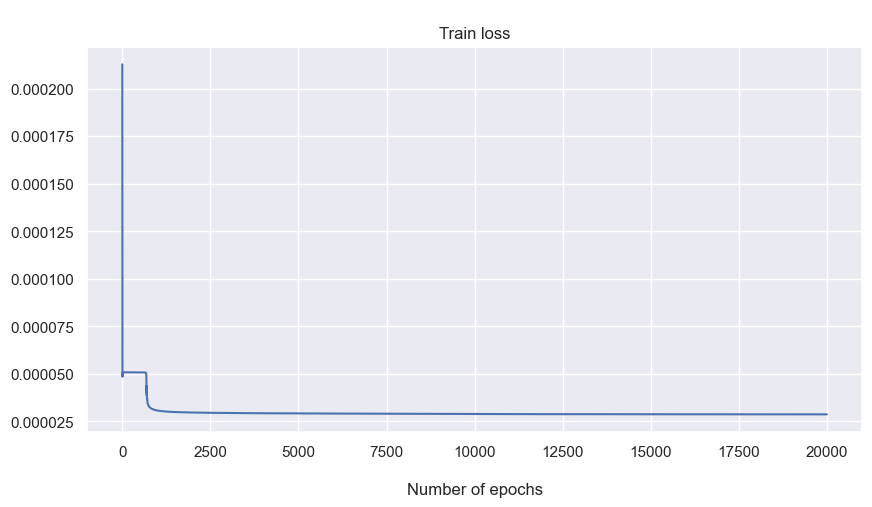

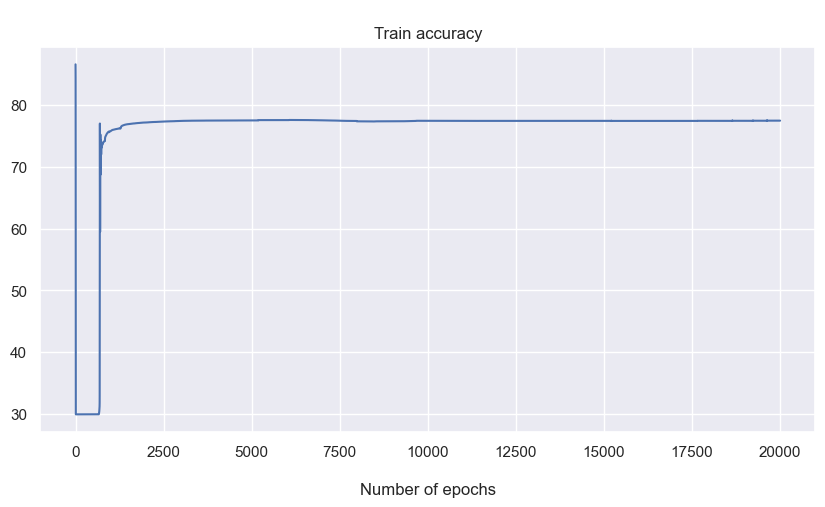

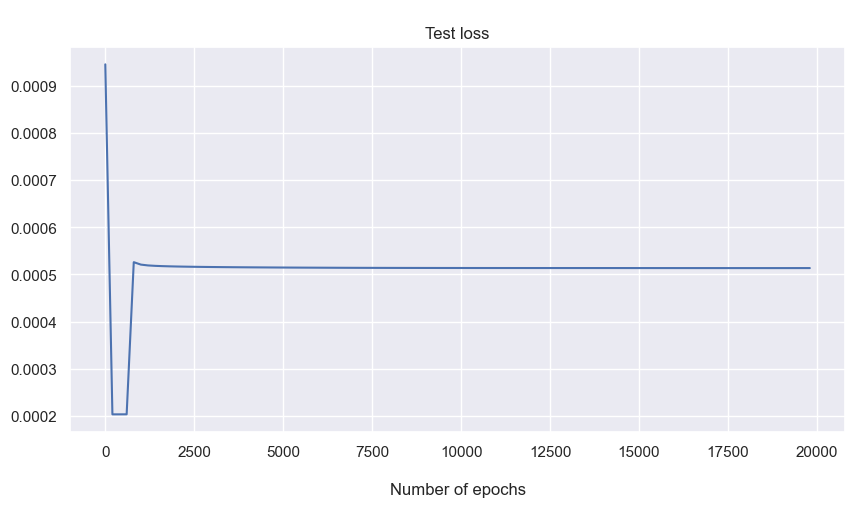

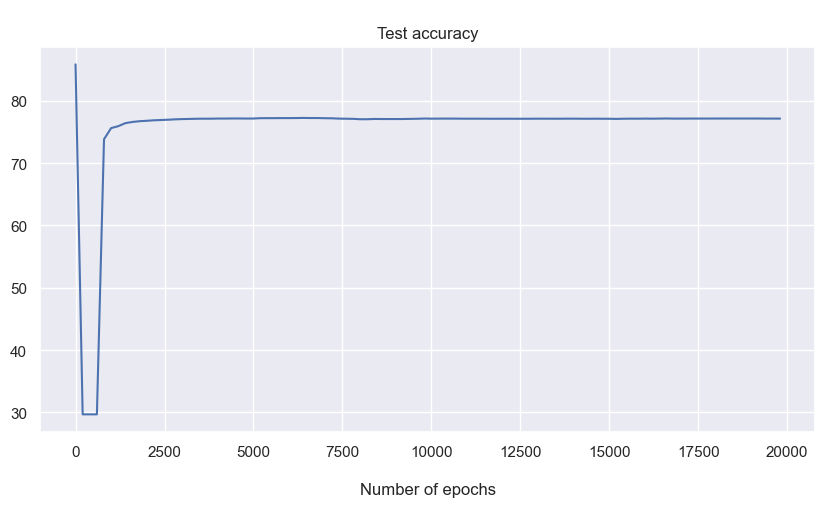

In [18]:
plt.plot(np.arange(0, epochs), train_losses)
plt.xlabel('\nNumber of epochs')
plt.title('\nTrain loss')
plt.show()

plt.plot(np.arange(0, epochs), train_accuracies)
plt.xlabel('\nNumber of epochs')
plt.title('\nTrain accuracy')
plt.show()

plt.plot(np.arange(0, epochs, 200), test_losses)
plt.xlabel('\nNumber of epochs')
plt.title('\nTest loss')
plt.show()

plt.plot(np.arange(0, epochs, 200), test_accuracies)
plt.xlabel('\nNumber of epochs')
plt.title('\nTest accuracy')
plt.show()